In [1]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.Plot as Plot
import HydroAI.Data as Data
importlib.reload(Plot);
importlib.reload(Data);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
import xgboost as xgb

In [3]:
# Combine conditions and return an array where 0 indicates clear and 1 indicates not clear
#Bits 7-6 (Aerosol Level)
#11: High aerosol concentration
#10: Moderate aerosol concentration
#01: Low aerosol concentration
#00: Climatology aerosol (default or typical value based on climatological data)
#
#Bit 5 (Water)
#1: Presence of water
#0: No water
#
#Bit 4 (Snow/Ice)
#1: Presence of snow/ice
#0: No snow/ice
#Bit 3 (Cloud Shadow)
#1: Presence of cloud shadow
#0: No cloud shadow
#Bit 2 (Adjacent to Cloud/Shadow)
#1: Proximity to cloud or shadow
#0: Not adjacent to cloud or shadow
#Bit 1 (Cloud)
#1: Presence of clouds
#0: No clouds
#Bit 0 (Cirrus)
#Reserved for future use or a specific purpose not yet implemented (NA).
def is_cloud(values):
    # Convert values to a numpy array if not already one
    values = np.array(values, dtype=np.uint8)

    # Check if all values are within the byte range
    if np.any((values < 0) | (values > 255)):
        raise ValueError("All values must be between 0 and 255")
    
    # Apply bitwise operations to check conditions across the entire array
    cloud_free = (values & (1 << 1)) == 0
    cloud_shadow_free = (values & (1 << 3)) == 0
    not_adjacent_to_cloud_shadow = (values & (1 << 2)) == 0

    # Combine conditions and return an array where 0 indicates clear and 1 indicates not clear
    return np.where(cloud_free & cloud_shadow_free & not_adjacent_to_cloud_shadow, 0, 1)

def is_water(values):
    # Convert values to a numpy array if not already one
    values = np.array(values, dtype=np.uint8)

    # Check if all values are within the byte range
    if np.any((values < 0) | (values > 255)):
        raise ValueError("All values must be between 0 and 255")

    # Apply bitwise operations to check water presence across the entire array
    water_present = (values & (1 << 5)) != 0

    # Return an array where 1 indicates water present and 0 indicates no water
    return np.where(water_present, 1, 0)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [4]:
data_path = '/Conferences/2024_수자원학회/SJ'
#S30_or = pd.read_csv(base_FP + data_path + '/merged_L30_obs_Juam.csv')
S30_or = pd.read_csv(base_FP + data_path + '/merged_S30_obs_Juam.csv')
#S30_or = pd.read_csv(base_FP + data_path + '/merged_S30_LSM_obs_Juam.csv')
S30_or.columns

Index(['Unnamed: 0', 'hls_date', 'wmcymd', 'time_delta', 'coastal', 'blue',
       'green', 'red', 'red_edge1', 'red_edge2', 'red_edge3', 'nir',
       'nir_narrow', 'water_vapor', 'cirrus', 'swir1', 'swir2', 'qa', 'wmdep',
       'itemLvl', 'itemAmnt', 'itemTemp', 'itemPh', 'itemDoc', 'itemBod',
       'itemCod', 'itemSs', 'itemTcoli', 'itemTn', 'itemTp', 'itemCd',
       'itemCn', 'itemPb', 'itemCr6', 'itemAs', 'itemHg', 'itemCu', 'itemAbs',
       'itemPcb', 'itemOp', 'itemMn', 'itemTrans', 'itemCloa', 'itemCl',
       'itemZn', 'itemCr', 'itemFe', 'itemPhenol', 'itemNhex', 'itemEc',
       'itemTce', 'itemPce', 'itemNo3n', 'itemNh3n', 'itemEcoli', 'itemPop',
       'itemDtn', 'itemDtp', 'itemFl', 'itemCol', 'itemAlgol', 'itemCcl4',
       'itemDceth', 'itemDcm', 'itemBenzene', 'itemChcl3', 'itemToc',
       'itemDehp', 'itemAntimon', 'itemDiox', 'itemHcho', 'itemHcb', 'itemNi',
       'itemBa', 'itemSe'],
      dtype='object')

In [6]:
# Data Pre-processing
S30 = S30_or.copy()
S30['time_delta'] = S30['time_delta']/60/60
S30.rename(columns={'time_delta':'time_delta_hr'}, inplace=True)
S30.rename(columns={'nir_narrow':'red_edge4'}, inplace=True)

S30_m = S30.copy()
S30_m['cloud'] = is_cloud(S30_m.qa)
S30_m['water'] = is_water(S30_m.qa)
#S30_m['chla_2b'] = S30_m.red_edge1/S30_m.red
#S30_m['chla_3b'] = (1/S30_m.red - 1/S30_m.red_edge1)*S30_m.red_edge2
S30_m = S30_m[(S30_m.cloud == 0) & (S30_m.water == 1) & (np.abs(S30_m.time_delta_hr)<=60)]

selected_X = ['blue', 'green', 'red', 'red_edge1', 'red_edge2', 'red_edge3', 'red_edge4',
              'nir', 'swir1', 'swir2']#, 
              #'Swnet_tavg', 'Lwnet_tavg', 'Qle_tavg','Qh_tavg', 'Evap_tavg', 'AvgSurfT_tavg',
              #'Wind_f_tavg', 'Tair_f_tavg','TotalPrecip_tavg', 'SoilMoist_tavg']

#selected_X = ['blue', 'green', 'red', 'tir1', 'tir2',
#              'nir', 'swir1', 'swir2']

selected_Y = ['itemCloa'] #, 'itemTemp']]
selected_columns = selected_X + selected_Y

S30_m = S30_m[selected_columns].dropna().reset_index().drop(columns='index')

# Split the data into features and target
X = S30_m[selected_X]
Y = S30_m[selected_Y].values.ravel()

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=321)

# Normalization scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test data
X_test_scaled = scaler.transform(X_test)

In [7]:
# 1. RF model (single target)
# Initial fit to determine feature importances
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train_scaled, Y_train)

# Get feature importances
importances = forest.feature_importances_

# Features above a certain threshold
threshold = np.sort(importances)[-8]  # adjust the threshold or number of features as needed
selected_features = [x for x, imp in zip(selected_X, importances) if imp >= threshold]

# Filter the training and testing sets to include only selected features
X_train_scaled = X_train_scaled[:, [selected_X.index(feature) for feature in selected_features]]
X_test_scaled = X_test_scaled[:, [selected_X.index(feature) for feature in selected_features]]

In [8]:
# Bayesian optimization setup
search_space = {
    'n_estimators': Integer(10, 200),  # reduced upper limit
    'max_depth': Integer(3, 100),  # lower max depth
    'min_samples_split': Integer(10, 100),  # increased minimum samples per split
    'min_samples_leaf': Integer(4, 100),  # increased minimum samples per leaf
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True]),  # ensuring bootstrap is used
    'max_leaf_nodes': Integer(10, 100)  # reduced max leaf nodes
}

# Create a pipeline with scaling and the random forest regressor
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=321))
])

# Initialize the Bayesian optimizer with the pipeline
opt = BayesSearchCV(
    rf_pipeline,
    {'rf__' + k: v for k, v in search_space.items()},
    n_iter=32,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Continue with the rest of your model fitting and evaluation
opt.fit(X_train_scaled, Y_train)
print("Best parameters:", opt.best_params_)
best_model = opt.best_estimator_

Y_test_pred = best_model.predict(X_test_scaled)
Y_train_pred = best_model.predict(X_train_scaled)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
print("Best parameters:", opt.best_params_)

Best parameters: OrderedDict([('rf__bootstrap', True), ('rf__max_depth', 100), ('rf__max_features', 'log2'), ('rf__max_leaf_nodes', 100), ('rf__min_samples_leaf', 4), ('rf__min_samples_split', 10), ('rf__n_estimators', 200)])


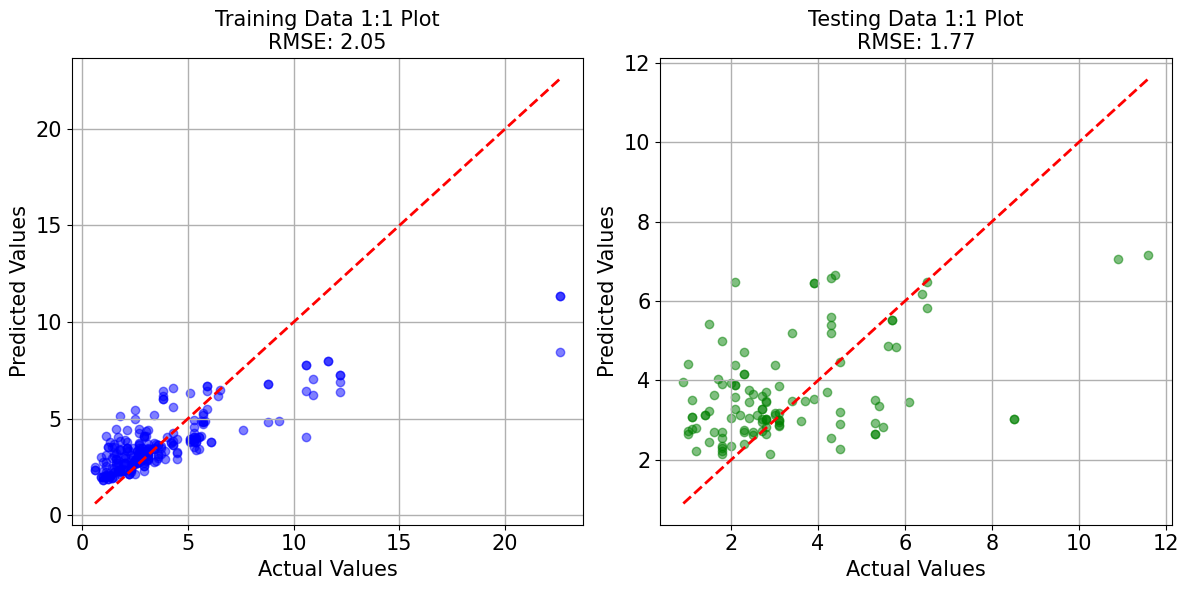

In [10]:
train_rmse = rmse(Y_train_pred, Y_train)
test_rmse = rmse(Y_test_pred, Y_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot for Training Results
ax[0].scatter(Y_train, Y_train_pred, alpha=0.5, color='blue')
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title(f'Training Data 1:1 Plot\nRMSE: {train_rmse:.2f}')
ax[0].grid(True)

# Plot for Testing Results
ax[1].scatter(Y_test, Y_test_pred, alpha=0.5, color='green')
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Predicted Values')
ax[1].set_title(f'Testing Data 1:1 Plot\nRMSE: {test_rmse:.2f}')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# 2. RF model (more than two targets)
# Data Pre-processing
S30 = pd.read_csv(base_FP + '/Conferences/2024_수자원학회/SJ/merged_S30_obs_Juam.csv')
S30['time_delta'] = S30['time_delta']/60/60
S30.rename(columns={'time_delta':'time_delta_hr'}, inplace=True)

S30_m = S30.copy()
S30_m['cloud'] = is_cloud(S30_m.qa)
S30_m['water'] = is_water(S30_m.qa)
S30_m = S30_m[(S30_m.cloud == 0) & (S30_m.water == 1) & (np.abs(S30_m.time_delta_hr)<=60)]

selected_X = ['blue', 'green', 'red', 'red_edge1', 'red_edge2', 'red_edge3',
              'nir', 'swir1', 'swir2']
selected_Y = ['itemCloa', 'itemTemp', 'itemBod']
selected_columns = selected_X + selected_Y

S30_m = S30_m[selected_columns].dropna().reset_index().drop(columns='index')

# Split the data into features and target
X = S30_m[selected_X]
Y = S30_m[selected_Y]

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=321)

# Normalization scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test data
X_test_scaled = scaler.transform(X_test)

# Initial fit to determine feature importances
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train_scaled, Y_train)

# Get feature importances
importances = forest.feature_importances_

# Features above a certain threshold
threshold = np.sort(importances)[-8]  # adjust the threshold or number of features as needed
selected_features = [x for x, imp in zip(selected_X, importances) if imp >= threshold]

# Filter the training and testing sets to include only selected features
X_train_scaled = X_train_scaled[:, [selected_X.index(feature) for feature in selected_features]]
X_test_scaled = X_test_scaled[:, [selected_X.index(feature) for feature in selected_features]]

# Bayesian optimization setup
search_space = {
    'n_estimators': Integer(10, 200),  # reduced upper limit
    'max_depth': Integer(3, 100),  # lower max depth
    'min_samples_split': Integer(10, 100),  # increased minimum samples per split
    'min_samples_leaf': Integer(4, 100),  # increased minimum samples per leaf
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True]),  # ensuring bootstrap is used
    'max_leaf_nodes': Integer(10, 100)  # reduced max leaf nodes
}

# Create a pipeline with scaling and the random forest regressor
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=321))
])

# Initialize the Bayesian optimizer with the pipeline
opt = BayesSearchCV(
    rf_pipeline,
    {'rf__' + k: v for k, v in search_space.items()},
    n_iter=32,
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Continue with the rest of your model fitting and evaluation
opt.fit(X_train_scaled, Y_train)
print("Best parameters:", opt.best_params_)
best_model = opt.best_estimator_

Y_test_pred = best_model.predict(X_test_scaled)
Y_train_pred = best_model.predict(X_train_scaled)

In [ ]:
Y_train_Cloa = Y_train['itemCloa']
Y_train_pred_Cloa = Y_train_pred[:,0]

Y_test_Cloa = Y_test['itemCloa']
Y_test_pred_Cloa = Y_test_pred[:,0]

train_rmse = rmse(Y_train_pred_Cloa, Y_train_Cloa)
test_rmse = rmse(Y_test_pred_Cloa, Y_test_Cloa)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot for Training Results
ax[0].scatter(Y_train_Cloa, Y_train_pred_Cloa, alpha=0.5, color='blue')
ax[0].plot([Y_train_Cloa.min(), Y_train_Cloa.max()], [Y_train_Cloa.min(), Y_train_Cloa.max()], '--r', linewidth=2)
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title(f'Training Data 1:1 Plot\nRMSE: {train_rmse:.2f}')
ax[0].grid(True)

# Plot for Testing Results
ax[1].scatter(Y_test_Cloa, Y_test_pred_Cloa, alpha=0.5, color='green')
ax[1].plot([Y_test_Cloa.min(), Y_test_Cloa.max()], [Y_test_Cloa.min(), Y_test_Cloa.max()], '--r', linewidth=2)
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Predicted Values')
ax[1].set_title(f'Testing Data 1:1 Plot\nRMSE: {test_rmse:.2f}')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# 3. SVR model (single target)
# Create a pipeline with scaling and the SVM regressor
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR())
])

# Define the search space for Bayesian optimization
search_spaces = {
    'svm__C': Real(0.1, 100, prior='log-uniform'),
    'svm__gamma': Real(0.001, 1, prior='log-uniform'),
    'svm__kernel': Categorical(['rbf', 'linear', 'sigmoid', 'poly']),
    'svm__degree': Integer(1, 5)  # Relevant for 'poly' kernel
}

# Initialize Bayesian optimization with the pipeline
svm_opt = BayesSearchCV(
    estimator=svm_pipeline,
    search_spaces=search_spaces,
    n_iter=32,  # Number of iterations to perform
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=321,
    verbose=1
)

# Fit the Bayesian optimizer
svm_opt.fit(X_train_scaled, Y_train)  # Note: No need to scale X_train here as it's done in the pipeline

# Best model and parameters found
print("Best SVM parameters:", svm_opt.best_params_)
best_svm_model = svm_opt.best_estimator_

# Make predictions
Y_test_pred_svm = best_svm_model.predict(X_test_scaled)  # X_test is automatically scaled in the pipeline
Y_train_pred_svm = best_svm_model.predict(X_train_scaled)

# Calculate and print RMSE or another metric
from sklearn.metrics import mean_squared_error
svm_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred_svm))
print("Test RMSE for SVM:", svm_test_rmse)

In [ ]:
train_rmse = rmse(Y_train_pred_svm, Y_train)
test_rmse = rmse(Y_test_pred_svm, Y_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot for Training Results
ax[0].scatter(Y_train, Y_train_pred_svm, alpha=0.5, color='blue')
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title(f'Training Data 1:1 Plot\nRMSE: {train_rmse:.2f}')
ax[0].grid(True)

# Plot for Testing Results
ax[1].scatter(Y_test, Y_test_pred_svm, alpha=0.5, color='green')
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Predicted Values')
ax[1].set_title(f'Testing Data 1:1 Plot\nRMSE: {test_rmse:.2f}')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [25]:
# XGB model (less over-fitting)
# Create a pipeline with scaling and the XGBoost regressor
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=321))
])

# Define the search space for Bayesian optimization
search_spaces = {
    'xgb__n_estimators': Integer(100, 500),  # Increased number of estimators
    'xgb__max_depth': Integer(3, 10),  # Reduced max depth to control complexity
    'xgb__learning_rate': Real(0.01, 0.1, prior='log-uniform'),  # Lower learning rate
    'xgb__subsample': Real(0.7, 1.0),  # Slightly more conservative subsample
    'xgb__colsample_bytree': Real(0.7, 1.0),  # More conservative feature sampling
    'xgb__min_child_weight': Integer(3, 10),  # Increased min child weight
    'xgb__gamma': Real(0.1, 1.0),  # Adding gamma to control loss reduction
    'xgb__lambda': Real(1, 10),  # L2 regularization
    'xgb__alpha': Real(0.1, 1.0)  # L1 regularization
}

# Initialize Bayesian optimization with the pipeline
xgb_opt = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=search_spaces,
    n_iter=32,  # Number of iterations to perform
    cv=10,  # Cross-validation folds
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=321,
    verbose=1
)

# Fit the Bayesian optimizer
xgb_opt.fit(X_train, Y_train)  # No need to scale X_train here as it's done in the pipeline

# Best model and parameters found
print("Best XGBoost parameters:", xgb_opt.best_params_)
best_xgb_model = xgb_opt.best_estimator_

# Make predictions
Y_test_pred_xgb = best_xgb_model.predict(X_test)  # X_test is automatically scaled in the pipeline
Y_train_pred_xgb = best_xgb_model.predict(X_train)

# Calculate and print RMSE
xgb_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred_xgb))
print("Test RMSE for XGBoost:", xgb_test_rmse)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

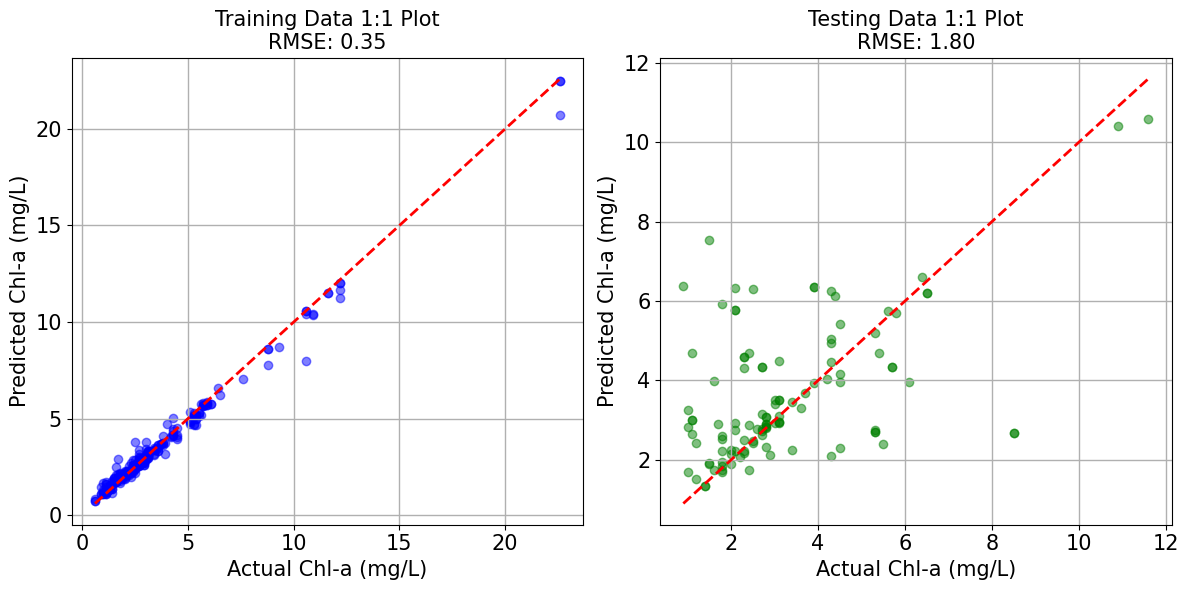

In [26]:
train_rmse = rmse(Y_train_pred_xgb, Y_train)
test_rmse = rmse(Y_test_pred_xgb, Y_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot for Training Results
ax[0].scatter(Y_train, Y_train_pred_xgb, alpha=0.5, color='blue')
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
ax[0].set_xlabel('Actual Chl-a (mg/L)')
ax[0].set_ylabel('Predicted Chl-a (mg/L)')
ax[0].set_title(f'Training Data 1:1 Plot\nRMSE: {train_rmse:.2f}')
ax[0].grid(True)

# Plot for Testing Results
ax[1].scatter(Y_test, Y_test_pred_xgb, alpha=0.5, color='green')
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
ax[1].set_xlabel('Actual Chl-a (mg/L)')
ax[1].set_ylabel('Predicted Chl-a (mg/L)')
ax[1].set_title(f'Testing Data 1:1 Plot\nRMSE: {test_rmse:.2f}')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
# XGB model (over-fitting)
# Create a pipeline with scaling and the XGBoost regressor
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=321))
])

# Define the search space for Bayesian optimization
search_spaces = {
    'xgb__n_estimators': Integer(50, 300),
    'xgb__max_depth': Integer(3, 100),
    'xgb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'xgb__subsample': Real(0.5, 1.0),
    'xgb__colsample_bytree': Real(0.5, 1.0),
    'xgb__min_child_weight': Integer(1, 10)
}

# Initialize Bayesian optimization with the pipeline
xgb_opt = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=search_spaces,
    n_iter=32,  # Number of iterations to perform
    cv=10,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=321,
    verbose=1
)

# Fit the Bayesian optimizer
xgb_opt.fit(X_train_scaled, Y_train)  # Note: No need to scale X_train here as it's done in the pipeline

# Best model and parameters found
print("Best XGBoost parameters:", xgb_opt.best_params_)
best_xgb_model = xgb_opt.best_estimator_

# Make predictions
Y_test_pred_xgb = best_xgb_model.predict(X_test_scaled)  # X_test is automatically scaled in the pipeline
Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)

# Calculate and print RMSE or another metric
from sklearn.metrics import mean_squared_error
xgb_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred_xgb))
print("Test RMSE for XGBoost:", xgb_test_rmse)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

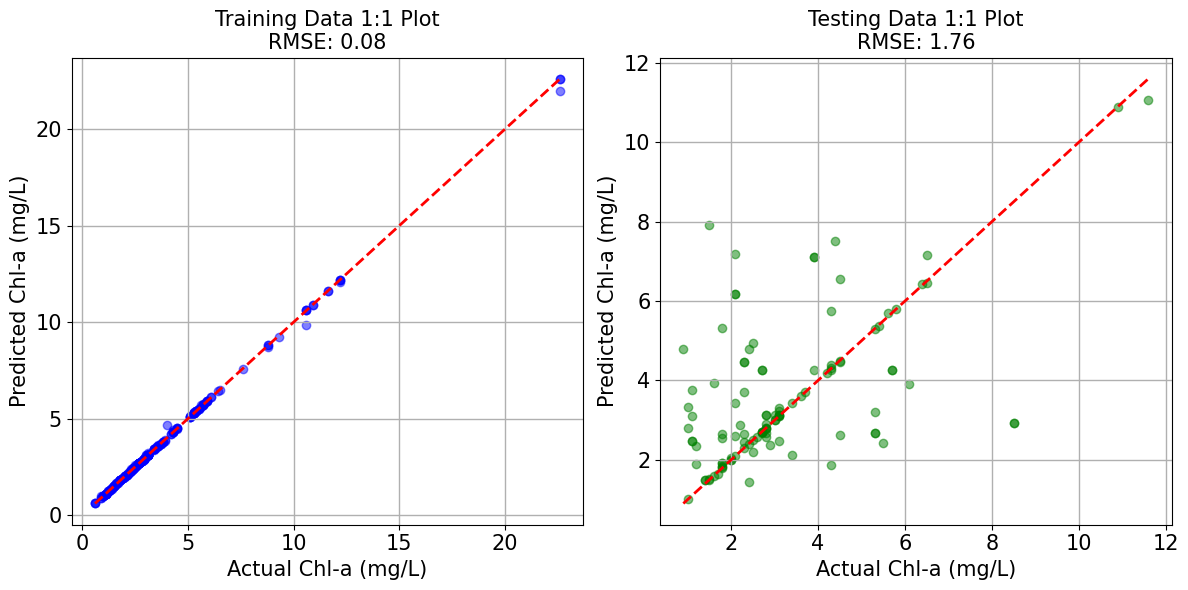

In [24]:
train_rmse = rmse(Y_train_pred_xgb, Y_train)
test_rmse = rmse(Y_test_pred_xgb, Y_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot for Training Results
ax[0].scatter(Y_train, Y_train_pred_xgb, alpha=0.5, color='blue')
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--r', linewidth=2)
ax[0].set_xlabel('Actual Chl-a (mg/L)')
ax[0].set_ylabel('Predicted Chl-a (mg/L)')
ax[0].set_title(f'Training Data 1:1 Plot\nRMSE: {train_rmse:.2f}')
ax[0].grid(True)

# Plot for Testing Results
ax[1].scatter(Y_test, Y_test_pred_xgb, alpha=0.5, color='green')
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', linewidth=2)
ax[1].set_xlabel('Actual Chl-a (mg/L)')
ax[1].set_ylabel('Predicted Chl-a (mg/L)')
ax[1].set_title(f'Testing Data 1:1 Plot\nRMSE: {test_rmse:.2f}')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import HydroAI.HLS as HLS
import netCDF4 as nc
nc_file = nc. Dataset ('/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/Conferences/2024_수자원학회/SJ/Pekel_Juam_resampled.nc', 'r')
pekel_water = nc_file.variables['pekel_data'] [:]
nc_file.close()

In [ ]:
target_date = '2023.09.29'
base_folder = base_FP + data_path + '/' + target_date

In [ ]:
feature_indices = [selected_X.index(feature) for feature in selected_features if feature in selected_X]
# Example usage to get any band values and lon/lat data:
s2_reader = HLS.SentinelBandReader(base_folder)

# Dynamically load band data using names in selected_X
band_data = [getattr(s2_reader, band) for band in selected_features if hasattr(s2_reader, band)]
# Stack all band data along the third axis
s2_data = np.dstack(band_data)
qa_data = s2_reader.qa*10000
lon, lat = s2_reader.get_lat_lon_arrays('red')

In [ ]:
cloud_mask = (is_cloud_2d == 0)  # mask where there are no clouds
water_mask = (is_water_2d == 1)  # mask where there is water
pekel_water_mask = (pekel_water > 0)  # mask where pekel water values are >= 5
# Combine all masks to a single mask where all conditions are true
final_mask = cloud_mask & pekel_water_mask

height, width, _ = s2_data.shape
pred_2d_xgb = np.full((height, width), np.nan)  # Initialize with NaNs

# Iterate only over the true elements in the mask
for i in range(height):
    for j in range(width):
        if final_mask[i, j]:  # Check if the conditions are met
            temp_x = s2_data[i, j, :]
            # Scale the features
            temp_x_scaled = (temp_x - scaler.mean_[feature_indices]) / scaler.scale_[feature_indices]
            # Predict using the XGBoost model
            temp_y = best_xgb_model.predict(temp_x_scaled.reshape(1, -1))
            # Store the prediction in the pred_2d_xgb array
            pred_2d_xgb[i, j] = temp_y

In [ ]:
bounds = [127.1, 127.3, 34.85, 35.1]
#bounds = [127.15, 127.275, 34.95, 35.075]
importlib.reload(Plot);
Plot.plot_map(lon, lat, pred_2d_xgb, 0, 10, plot_title=target_date + (' (Juam Dam; XGBoost)'), label_title=' Chlorophyll a (mg/L)', cmap='jet', projection='PlateCarree', bounds=bounds, dem_path=None)